# Synthetic gravity data

This code calculates the gravity anomaly produced by a synthetic body. The synthetic data are calculated by using the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/).

### Import the required stuff

In [1]:
# Set PySide compatible APIs
import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
#comment this command if you want to create a new model
%matplotlib inline

In [14]:
import numpy as np
import cPickle as pickle
from IPython.display import Image as img
from fatiando import mesher, gridder
from fatiando.gravmag import polyprism, transform
from fatiando.vis import mpl, myv

### Create a synthetic body

The synthetic body is formed by four [polygonal prisms](http://www.fatiando.org/api/mesher.html#fatiando.mesher.PolygonalPrism). These prisms are vertically juxtaposed, the top of the shallowest prism is at 100 m, the bottom of the deepest prism is at 2100 m and the density of all prisms is 500 km/cm<sup>3</sup>. The x, y, and z axes of the Cartesian coordinate system point, respectively, to North, East and to depth.

In [4]:
bounds = [-10000, 10000, -10000, 10000, 0, 5000]
area = bounds[:4]
depths = [100, 600, 1100, 1600, 2100]

In [5]:
#change this cell from `Raw NBConvert` to `Code` if you want to load a model
#by using the Python pickle module (https://docs.python.org/2/library/pickle.html)
with open('model.pickle') as f:
        model = pickle.load(f)

### Calculate the gravity anomaly at a constant plane

The synthetic gravity anomaly is calculated at a constant z<sub>0</sub> = -100 m, on a regular grid of 141 $\times$ 80 points along, respectively, the x and y axes of the Cartesian coordinate system.

In [6]:
# grid of points (xp, yp, zp) on which the gravity anomaly is calculated
shape = (141, 80)
z0 = -100
xp, yp, zp = gridder.regular(area, shape, z=z0)

dx, dy = gridder.spacing(area, shape)

# gravity anomaly (in mGal)
gz = polyprism.gz(xp, yp, zp, model)

In [7]:
print 'dx = %.5f \ndy = %.5f' % (dx, dy) 

dx = 142.85714 
dy = 253.16456


In [8]:
#Save the synthetic gravity anomaly in a txt file
header = """# Noise-free gravity anomaly calculated at z = {z} m, 
#on a regular grid of points
# shape (nx, ny): {shape}
# area [x1, x2, y1, y2]: {area}
# spacing (dx, dy): {spacing}
# x (m)    y (m)    z (m)    gravity anomaly (mGal)
""".format(z=z0, shape=shape, area=area, spacing=(dx, dy))
file_name = 'gravity_anomaly.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp, yp, zp, gz), fmt='%.5f')

In [9]:
#Save the synthetic gravity anomaly in a txt file
profile = (xp == 0.)
header = """# Noise-free gravity anomaly calculated at z = {z} m, 
#on the profile x = 0 m
# x (m)    y (m)    z (m)    gravity anomaly (mGal)
""".format(z=z0)
file_name = 'gravity_anomaly_profile.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp[profile], yp[profile], zp[profile], gz[profile]), fmt='%.5f')

### Plot the synthetic data

Anomaly map

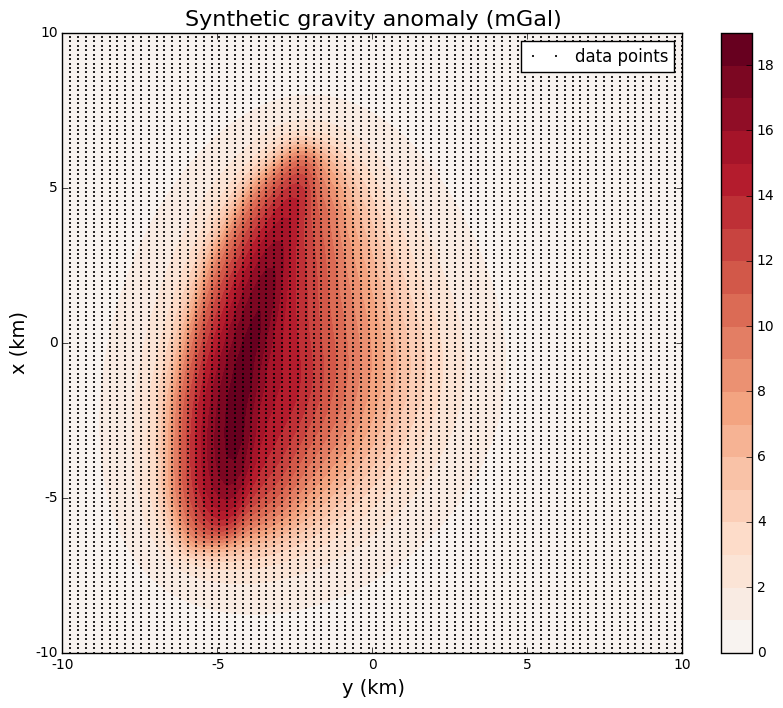

In [10]:
ranges = np.max(np.abs([np.min(gz), np.max(gz)]))
mpl.figure(figsize=(10,8))
mpl.axis('scaled')
mpl.title("Synthetic gravity anomaly (mGal)", fontsize=16)
mpl.contourf(yp, xp, gz, shape, 20, cmap=mpl.get_cmap('RdBu_r'),
            vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.plot(yp, xp, '.k', markersize=2, label='data points')
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('x (km)', fontsize=14)
mpl.set_area(area)
mpl.legend(loc='upper right')
mpl.m2km()
mpl.savefig('map.png')
mpl.show()

Profile at x = 0 m

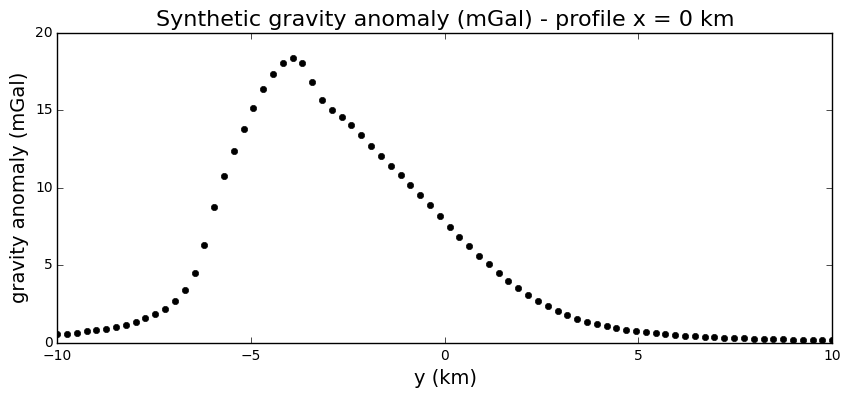

In [11]:
mpl.figure(figsize=(10,4))
mpl.title("Synthetic gravity anomaly (mGal) - profile x = 0 km", fontsize=16)
mpl.plot(0.001*yp[profile], gz[profile], '.k', markersize=10)
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('gravity anomaly (mGal)', fontsize=14)
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.savefig('profile.png')
mpl.show()

### Plot the synthetic body

In [12]:
# Show the model
scene=myv.figure(size=(600,500))
myv.polyprisms(model, 'density')
myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])

scene.scene.camera.position = [-45893.530845938621, -15145.201752891464, -25039.48539632967]
scene.scene.camera.focal_point = [-444.56066945604118, -2065.8995815899721, 1099.9999999999832]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.48341530978694358, 0.064881785059688557, -0.87298338599944825]
scene.scene.camera.clipping_range = [31071.114118358404, 86583.208366893625]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.savefig('model.png')
myv.show()

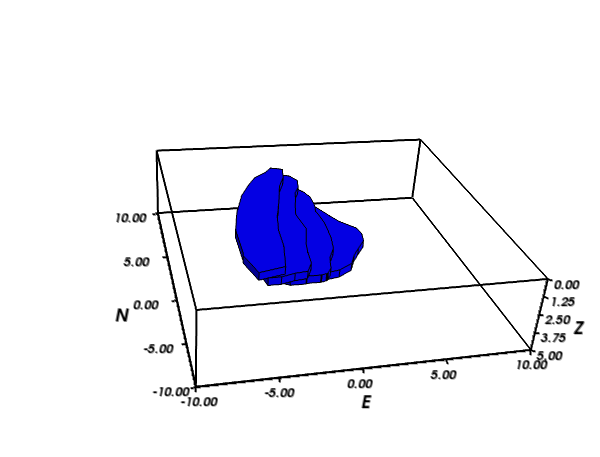

In [13]:
img('model.png')

### Laplaciano 

In [15]:
gzxx = transform.derivx(xp, yp, gz, shape, order=2, method='fft')
gzyy = transform.derivy(xp, yp, gz, shape, order=2, method='fft')
gzzz = transform.derivz(xp, yp, gz, shape, order=2, method='fft')

In [16]:
laplacian = gzxx + gzyy + gzzz

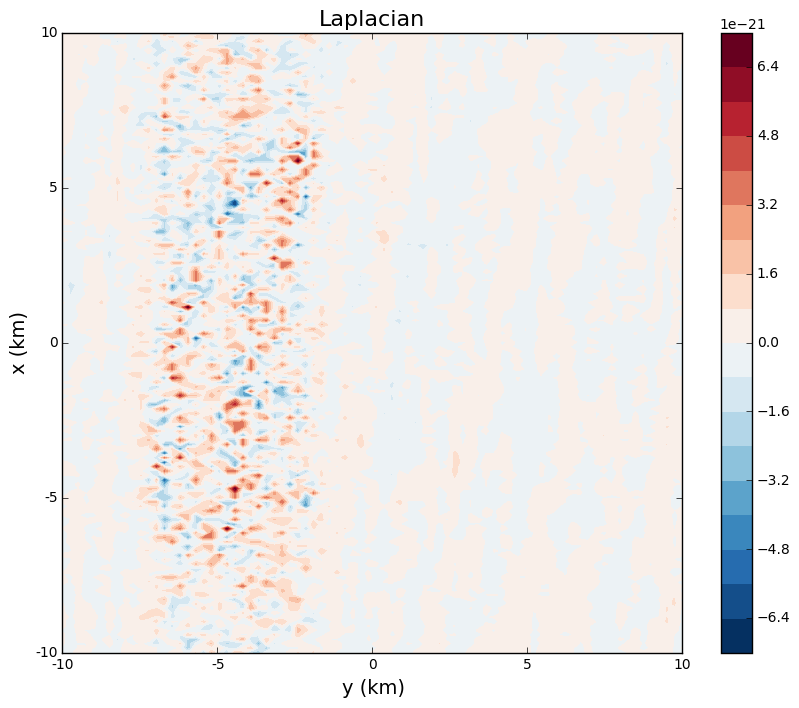

In [18]:
ranges = np.max(np.abs([np.min(laplacian), np.max(laplacian)]))
mpl.figure(figsize=(10,8))
mpl.axis('scaled')
mpl.title("Laplacian", fontsize=16)
mpl.contourf(yp, xp, laplacian, shape, 20, cmap=mpl.get_cmap('RdBu_r'),
            vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('x (km)', fontsize=14)
mpl.set_area(area)
mpl.m2km()
mpl.savefig('laplacian_grav.png')
mpl.show()